# Fake News Project
The goal of this project is to create a fake news prediction system. Fake news is a major problem that can have serious negative effects on how people understand the world around them. You will work with a dataset containing real and fake news in order to train a simple and a more advanced classifier to solve this problem. This project covers the full Data Science pipeline, from data processing, to modelling, to visualization and interpretation.

We ran the notebook with the following specs:
- CPU: Intel(R) Xeon(R) CPU E5-2687W v3 @ 3.10GHz
- Cores: 10
- Threads: 20
- Memory: 64GB Ram
# Part 1 Data Processing

## Task 1

Pandas is used to process The fake news corpus. Since content will be used for our models we drop any rows that don't have any content. 

In [1]:
import pandas as pd 

df = pd.read_csv("news_sample.csv")
dfcpy = df.copy()
dfcpy = dfcpy.dropna(subset=['content'])

In [2]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

We've implemented data processing functions to do the following:
- Clean the text
- Tokenize the text
- Remove stopwords
- Remove word variations with stemming

We use nltk because it has built-in support for many of these operations.

In [15]:
import re
import nltk
from nltk.tokenize.regexp import RegexpTokenizer
from nltk.stem import PorterStemmer
from collections import Counter
from cleantext import clean

def clean_text(text):
  clean_text = re.sub(r'([A-Z][A-z]+.?) ([0-9]{1,2}?), ([0-9]{4})', '<DATE>', text)
  clean_text = clean(clean_text,
    lower=True,
    no_urls=True, replace_with_url="<URL>",
    no_emails=True, replace_with_email="<EMAIL>",
    no_numbers=True, replace_with_number= r"<NUM>",
    no_currency_symbols=True, replace_with_currency_symbol="<CUR>",
    no_punct=True, replace_with_punct="",
    no_line_breaks=True 
  )
  return clean_text

def rmv_stopwords(tokens):
  stop_words = set(nltk.corpus.stopwords.words('english'))
  tokens = [word for word in tokens if word not in stop_words]
  return tokens

def stem_tokens(tokens):
  stemmer=PorterStemmer()
  Output=[stemmer.stem(word) for word in tokens]
  return Output

def build_vocabulary(df_tokens):
  tokens = []
  for lst in df_tokens:
    tokens += lst
  token_counter = Counter(tokens)
  return token_counter

In [4]:
dfcpy = df.copy()

dfcpy.content = dfcpy.content.apply(clean_text)

tokenizer = RegexpTokenizer(r'<[\w]+>|[\w]+')
dfcpy["tokenized"] = dfcpy.content.apply(tokenizer.tokenize)

vocab = build_vocabulary(dfcpy.tokenized)
vocab_size = len(vocab)
print("After cleaning:")
print(f"vocabulary size: {vocab_size}\n")

dfcpy.tokenized = dfcpy.tokenized.apply(rmv_stopwords)
vocab = build_vocabulary(dfcpy.tokenized)
# reduction rate of the vocabulary size
reduction = ((vocab_size - len(vocab))/vocab_size)*100
vocab_size = len(vocab)
print("After removing stopwords:")
print(f"vocabulary size: {vocab_size}")
print(f"reduction rate of the vocabulary size: {reduction:.2f}%\n")

dfcpy.tokenized = dfcpy.tokenized.apply(stem_tokens)
vocab = build_vocabulary(dfcpy.tokenized)
reduction = ((vocab_size - len(vocab))/vocab_size)*100
vocab_size = len(vocab)
print("After stemming:")
print(f"vocabulary size: {vocab_size}")
print(f"reduction rate of the vocabulary size: {reduction:.2f}%\n")

After cleaning:
vocabulary size: 16577

After removing stopwords:
vocabulary size: 16445
reduction rate of the vocabulary size: 0.80%

After stemming:
vocabulary size: 11031
reduction rate of the vocabulary size: 32.92%



## Task 2

We apply our data processing pipeline from task 1 on the *995k FakeNewsCorpus*. 

Pandas is slow when used on bigger amounts of data, this is because it dosen't allow for multithreading. Modin and ray are libaries that optimize pandas by allowing pandas to run on all cores, thereby giving a speed up for the data processing. By using modin with ray as an engine you can use pandas as usual, but have it use all threads in the CPU. We used a Intel Xeon cpu with 20 threads and therefore saw huge performance gain by using modin. 

Modin and ray can be installed by running the following command:
pip install "modin[ray]"

In [5]:
import modin.config as modin_cfg
modin_cfg.Engine.put("ray") # make sure to use Ray engine and other than could be installed
import modin.pandas as pd

In [6]:
# only read the columns we need
df = pd.read_csv("995,000_rows.csv", 
                 usecols=['content', 'type', 'title', 'domain'], 
                 engine='c', 
                 dtype = str)
dfcpy = df.copy()
dfcpy = dfcpy.dropna(subset=['content'])
dfcpy = dfcpy.dropna(subset=['type'])
dfcpy = dfcpy.dropna(subset=['title'])

2024-04-02 19:53:36,957	INFO worker.py:1752 -- Started a local Ray instance.


In [7]:
from time import time
start = time()
dfcpy.title = dfcpy.title.apply(clean_text)
dfcpy.content = dfcpy.content.apply(clean_text)
print(f"time to clean the data: {time() - start:.2f} sec")

t = time()
tokenizer = RegexpTokenizer(r'<[\w]+>|[\w]+')
dfcpy.title = dfcpy.title.apply(tokenizer.tokenize)
dfcpy.content = dfcpy.content.apply(tokenizer.tokenize)
print(f"time to tokenize the data: {(time() - t)/60:.2f} min" )

t = time()
dfcpy.title = dfcpy.title.apply(rmv_stopwords)
dfcpy.content = dfcpy.content.apply(rmv_stopwords)
print(f"time to remove stopwords: {(time() - t)/60:.2f} min")

t = time()
dfcpy.title = dfcpy.title.apply(stem_tokens)
dfcpy.content = dfcpy.content.apply(stem_tokens)
print(f"time to stem the data: {(time() - t)/60:.2f} sec")

print(f"total time: {(time() - start)/60:.2f} min")

time to clean the data: 21.82 sec
time to tokenize the data: 9.27 min
time to remove stopwords: 1.67 min
time to stem the data: 1.65 sec
total time: 12.96 min


(raylet) [2024-04-02 20:04:36,876 E 14353 14353] (raylet) node_manager.cc:2967: 3 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: e08b31605fb17e00a93e5c9c60a20ccc71f93e8c8c669311043b7061, IP: 10.3.32.4) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 10.3.32.4`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.
(raylet) [2024-04-02 20:05:36,878 E 14353 14353] (raylet) node_manager.cc:2967: 3 Workers (tasks / actors) killed due to me

(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: db940c539036c98e50d4183304635b2164d14ac601000000 Worker ID: 7e12927b58548ea6150e35d5407c0343e5051661126b8e38b20327e1 Node ID: e08b31605fb17e00a93e5c9c60a20ccc71f93e8c8c669311043b7061 Worker IP address: 10.3.32.4 Worker port: 32885 Worker PID: 14446 Worker exit type: SYSTEM_ERROR Worker exit detail: Worker unexpectedly exits with a connection error code 2. End of file. There are some potential root causes. (1) The process is killed by SIGKILL by OOM killer due to high memory usage. (2) ray stop --force is called. (3) The worker is crashed unexpectedly due to SIGSEGV or other unexpected errors.


(raylet) [2024-04-02 20:06:36,880 E 14353 14353] (raylet) node_manager.cc:2967: 3 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: e08b31605fb17e00a93e5c9c60a20ccc71f93e8c8c669311043b7061, IP: 10.3.32.4) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 10.3.32.4`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.
(raylet) [2024-04-02 20:16:37,634 E 14353 14353] (raylet) node_manager.cc:2967: 2 Workers (tasks / actors) killed due to me

## Data exploration

We've explored the dataset and made some observations which are used to determine importance of certain metadata in the fake news corpus, such observations are:

- The amount of numerics in the dataset
- The 100 most frequent words
- The 20 most frequent domains and how their articles are classified in terms of type
- The distrubtion of types in the dataset
- The amount of rows missing content, title or type (amount of rows that will be dropped from the dataset). 

In [8]:
start = time()
vocab_content = build_vocabulary(dfcpy.content)
print(f"time to build vocabulary for content: {(time() - start)/60:.2f} min")

start = time()
vocab_title = build_vocabulary(dfcpy.title)
print(f"time to build vocabulary for title: {(time() - start)/60:.2f} min")

time to build vocabulary for content: 18.94 min
time to build vocabulary for title: 0.08 min


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
# plot the frequency of the top n words
def plot_freq(counter, top_n):
  common_words = counter.most_common(top_n)

  all_freq = {}
  for word, freq in common_words:
    all_freq[word] = freq

  plt.figure(figsize = (top_n*0.1, 5))
  plt.xticks(rotation = 90,fontsize = 5)
  sns.lineplot(x = list(all_freq.keys()), y = list(all_freq.values()), color = 'red')
  sns.barplot(x = list(all_freq.keys()), y = list(all_freq.values()))
  plt.title(f'Top {top_n} most common words')
  plt.xlabel('Words')
  plt.ylabel('Frequency')
  plt.grid(axis = 'y')
  plt.show()
  return

def plot_domain_with_type(df):
  top_domains = df.domain.value_counts().head(20).index
  df = df[df.domain.isin(top_domains)]
  df = df.groupby(['domain', 'type']).size().unstack().fillna(0)

  df.plot(kind='bar', stacked=True, figsize=(10,5), title='Domain distribution with types')
  plt.show()
  return

numerics in content:  7530933


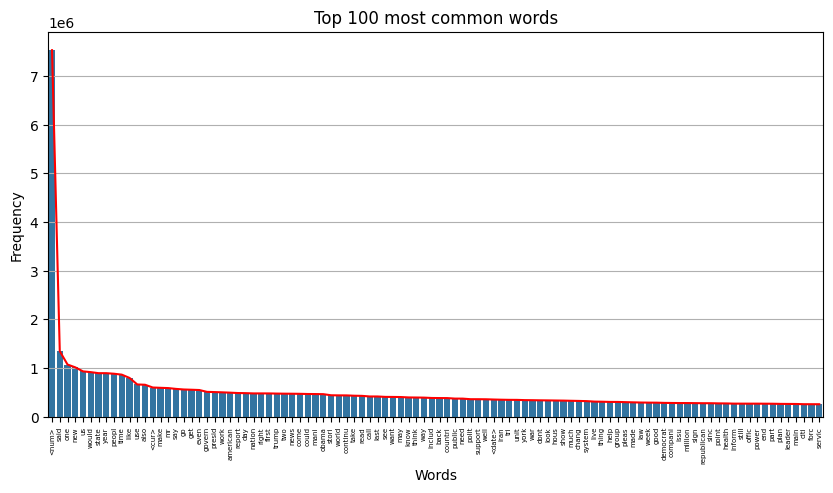

numerics in titles:  170894


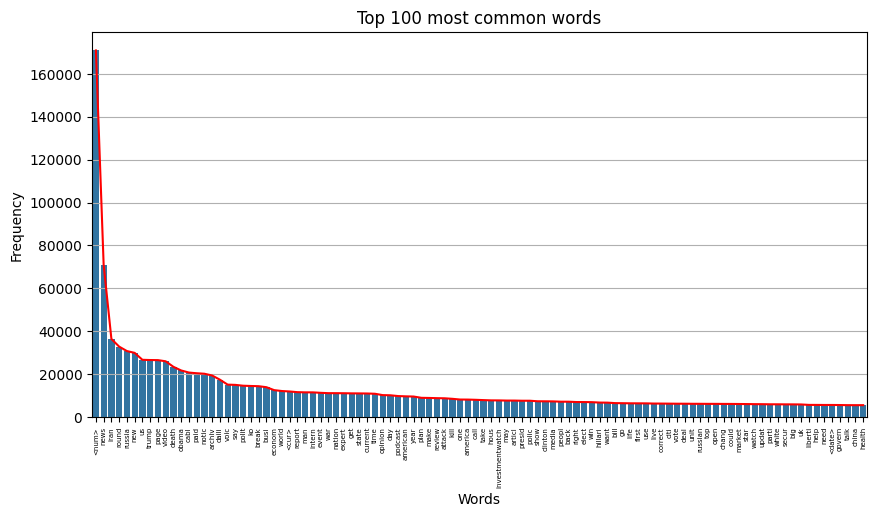

the groupby keys will be sorted anyway, although the 'sort=False' was passed. See the following issue for more details: https://github.com/modin-project/modin/issues/3571.


(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: 862a43f6ea08922a18a9cf3d5f68dff17e5fd86301000000 Worker ID: 27977a9715984320a34780ae66061076bc125119d0cd8a1e97fa5139 Node ID: e08b31605fb17e00a93e5c9c60a20ccc71f93e8c8c669311043b7061 Worker IP address: 10.3.32.4 Worker port: 43795 Worker PID: 14450 Worker exit type: SYSTEM_ERROR Worker exit detail: The leased worker has unrecoverable failure. Worker is requested to be destroyed when it is returned. RPC Error message: Socket closed; RPC Error details: 


(raylet) [2024-04-02 20:26:45,994 E 14353 14353] (raylet) node_manager.cc:2967: 1 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: e08b31605fb17e00a93e5c9c60a20ccc71f93e8c8c669311043b7061, IP: 10.3.32.4) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 10.3.32.4`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.


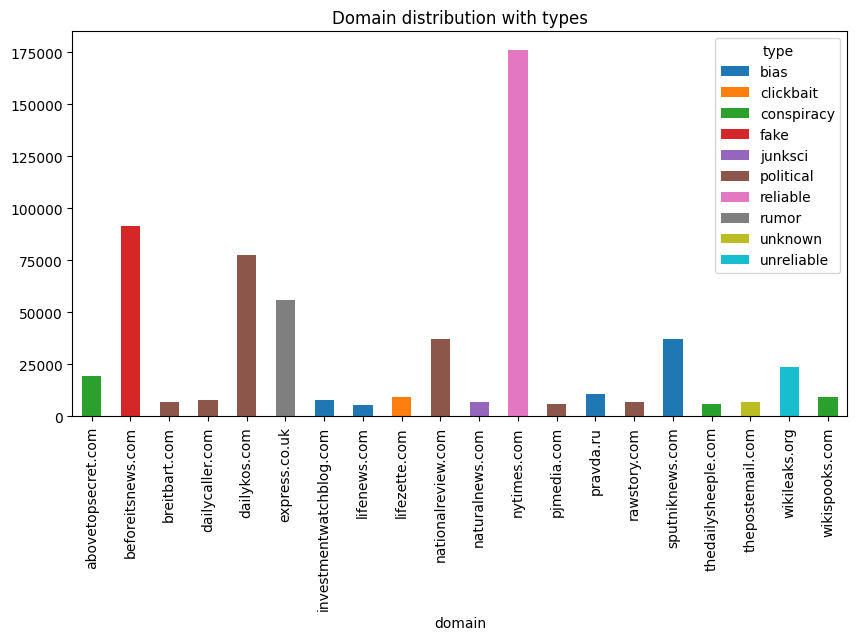

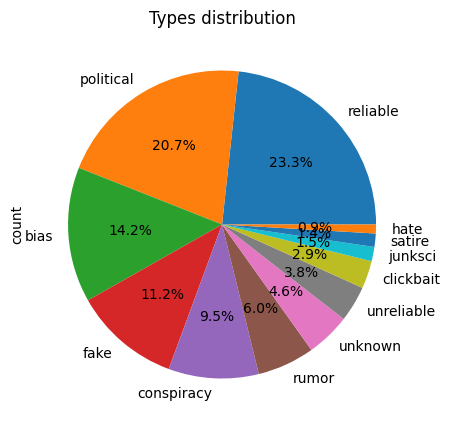

Number of dropped rows: 56368


In [10]:
# top 100 most frequent words
print("numerics in content: ", vocab_content["<num>"])
plot_freq(vocab_content, 100)
print("numerics in titles: ", vocab_title["<num>"])
plot_freq(vocab_title, 100)

# top 20 domains with their types
plot_domain_with_type(dfcpy)

# pie chart for the distribution of the types
dfcpy.type.value_counts().plot.pie(autopct='%1.1f%%', figsize=(10,5), title='Types distribution')
plt.show()

# ammount of dropped rows
print(f"Number of dropped rows: {df.shape[0] - dfcpy.shape[0]}")

When exporting the cleaned dataset we have to make sure the tokens are stored correctly in the csv. A csv can correctly store a python list, therefore we store the tokens as a string using space as a seperator for each token.

In [ ]:
dfcpy.content = dfcpy.content.apply(lambda x: ' '.join(x))
dfcpy.title = dfcpy.title.apply(lambda x: ' '.join(x))
dfcpy.to_csv('cleaned_news.csv', index=False)
print("done cleaning the data")

# shutdown the ray engine to free up the memory
import ray 
ray.shutdown()

# Task 4

Using the types we label articles as either fake or reliable. Some article types are omitted since it's ambigious wheter they are fake news or not. 

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('cleaned_news.csv', usecols=['content', 'type', 'title'], engine='c', dtype = str)
dfcpy = df.copy()

# label is 1 if the article is fake, 0 if the article is reliable
dfcpy['label'] = dfcpy['type'].map({'fake': 1, 
                                    'conspiracy': 1, 
                                    'junksci': 1, 
                                    'bias': 1, 
                                    'clickbait': 0, 
                                    'political': 0, 
                                    'reliable': 0})
dfcpy = dfcpy.dropna(subset=['label'])
dfcpy['label'] = dfcpy['label'].astype(int)

dfcpy = dfcpy.dropna(subset=['content'])
dfcpy = dfcpy.dropna(subset=['title'])

We split the dataset into a random 80/10/10 split where 80% is used for training. 10% is used for validation and 10% is used for testing. 

In [5]:
from sklearn.model_selection import train_test_split
# Splitting the data into training (80%) and the rest (20%)
train_df, rest_df = train_test_split(dfcpy, test_size=0.2, random_state=42, stratify=dfcpy['label'])
# Splitting the rest into validation (50%) and test (50%)
validation_df, test_df = train_test_split(rest_df, 
                                          test_size=0.5, 
                                          random_state=42, 
                                          stratify=rest_df['label'])

content_train, title_train ,y_train = train_df['content'], train_df['title'], train_df['label']
content_val, title_val, y_val = validation_df['content'], validation_df['title'], validation_df['label']
content_test, title_test, y_test = test_df['content'], test_df['title'], test_df['label']

print("Training Set:")
print(train_df.content.head())
print(train_df.title.head())

Training Set:
779426    <num> year old iranian man share life iran wor...
51493     love love harlem said could walk favorit resta...
325203    plu one articl googl plu thank ali alfoneh ass...
272377    larri silverstein caught admit camera plan bui...
38281     artifici intellig complex creator cant trust m...
Name: content, dtype: object
779426                                 tale iranian blogger
51493                     home daniel brook orang new black
325203                                      iran news round
272377                             news wire mintpress news
38281     artifici intellig complex creator cant trust m...
Name: title, dtype: object


We plot the Distrubution of Fake and reliable articles to get and idea on wheter our data is balanced or not

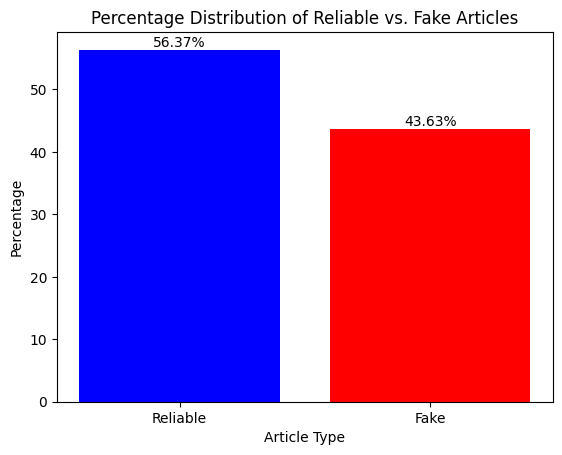

In [14]:
# Examine the percentage distribution of 'reliable' vs. 'fake' articles
grouped_type = dfcpy['label'].value_counts()
grouped_type = grouped_type / grouped_type.sum() * 100

# make a bar plot with percentages on bars
plt.bar([0, 1], grouped_type, tick_label=['Reliable', 'Fake'], color=['blue', 'red'])
plt.text(0, grouped_type[0], f'{grouped_type[0]:.2f}%', ha='center', va='bottom')
plt.text(1, grouped_type[1], f'{grouped_type[1]:.2f}%', ha='center', va='bottom')
plt.xlabel('Article Type')
plt.ylabel('Percentage')
plt.title('Percentage Distribution of Reliable vs. Fake Articles')
plt.show()

Importing and cleaning extra reliable articles scraped from BBC news. 

In [22]:
df_extra = pd.read_csv("scraped_articles.csv", usecols=['content'])
df_extra_cpy = df_extra.copy()
df_extra_cpy = df_extra_cpy.dropna(subset=['content'])
df_extra_cpy.content = df_extra_cpy.content.apply(clean_text)
tokenizer = RegexpTokenizer(r'<[\w]+>|[\w]+')
df_extra_cpy.content = df_extra_cpy.content.apply(tokenizer.tokenize)
df_extra_cpy.content = df_extra_cpy.content.apply(rmv_stopwords)
df_extra_cpy.content = df_extra_cpy.content.apply(stem_tokens)
df_extra_cpy['label'] = 0


df_extra_cpy.content = df_extra_cpy.content.apply(lambda x: ' '.join(x))
x_train_extra = pd.concat([content_train, df_extra_cpy.content], ignore_index=True)
y_train_extra = pd.concat([y_train, df_extra_cpy.label], ignore_index=True)

In [17]:
import seaborn as sns
from sklearn import metrics
def make_confusion_matrix(y_val, y_pred,model_name):
    confusion_matrix = metrics.confusion_matrix(y_val, y_pred, labels=[1, 0])
    sns.heatmap(confusion_matrix, 
                annot=True, 
                fmt='g', 
                cmap='Blues', 
                xticklabels=['real', 'fake'], 
                yticklabels=['real', 'fake'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{model_name}')
    plt.show()

# Part 2: A simple model

We use logistic regression for our simple model. The model is simple in terms of vector representation (bag of words) and lack of hyperparameter tuning.

In [24]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import sklearn.metrics as metrics
from scipy.sparse import hstack
from joblib import dump

vectorrizer = CountVectorizer(lowercase = False, max_features = 5000, token_pattern=r'<[\w]+>|[\w]+')
pipeline = Pipeline([
    ('vectorizer', vectorrizer), 
    ('scaler', StandardScaler(with_mean=False))
    ])

model = LogisticRegression(max_iter=10000, random_state=42)

# making bag of words for the content and extra data
BoW_extra = pipeline.fit_transform(x_train_extra)
BoW_content_val = pipeline.transform(content_val)

# Model with only content, but with extra data
model.fit(BoW_extra, y_train_extra)
y_pred = model.predict(BoW_content_val)
accuracy = metrics.accuracy_score(y_val, y_pred)
f1 = metrics.f1_score(y_val, y_pred)
print("Only content, but with extra data:")
print("f1 score:", f1)
print("accuracy:", accuracy)

# mkain bag of words for the content
BoW_content_train = pipeline.fit_transform(content_train)
BoW_content_val = pipeline.transform(content_val)
content_test_bow = pipeline.transform(content_test)


# Model with only content
model.fit(BoW_content_train, y_train)
y_pred = model.predict(BoW_content_val)
accuracy = metrics.accuracy_score(y_val, y_pred)
f1 = metrics.f1_score(y_val, y_pred)
print("Only content:")
print("f1 score:", f1)
print("accuracy:", accuracy)
# saving the model
dump(model, 'models/simple_model_content.joblib')

# making bag of words for the title and content
BoW_title_train = pipeline.fit_transform(title_train)
BoW_title_val = pipeline.transform(title_val)
BoW_combined_train = hstack((BoW_content_train, BoW_title_train))
BoW_combined_val = hstack((BoW_content_val, BoW_title_val))

# Model with content and title
model.fit(BoW_combined_train, y_train)
y_pred = model.predict(BoW_combined_val)
accuracy = metrics.accuracy_score(y_val, y_pred)
f1 = metrics.f1_score(y_val, y_pred)
print("\nContent and title:")
print("f1 score:", f1)
print("accuracy:", accuracy)
# saving the model
dump(model, 'models/simple_model_combined.joblib')

Only content, but with extra data:
f1 score: 0.8240011926058439
accuracy: 0.8488928708562652
Only content:
f1 score: 0.8239501683903079
accuracy: 0.8487904774094458

Content and title:
f1 score: 0.860425111812484
accuracy: 0.8805708434660182


['models/simple_model_combined.joblib']

# Part 3: Advanced model

We have tried 3 models: 
- LinearSVM
- Naive bayes
- Logistic regression (using TF-IDF and cross validation)

We tried 2 vector representations:
- TF-IDF (1, 2 and 3 grams )
- Word embedding (word2vec)

We perfrom cross validation (gridsearch) on hyper paramaters to find the best hyperparameters for each model 

## Model 1: Linear SVC 

In [3]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics
from joblib import dump

def svm(x_train, y_train, x_val, model_name):
    svc = LinearSVC(max_iter=10000, dual=False, random_state=42) 
    parameters = dict(C=[0.1, 1, 10, 20 , 50, 100])
    # Cross-validation
    grid_search = GridSearchCV(svc, parameters, cv=3, n_jobs=-1, scoring = 'f1', pre_dispatch=3)
    grid_search.fit(x_train, y_train)

    best_params = grid_search.best_params_
    print("Best Parameters for svm:", best_params)

    dump(grid_search, f'models/{model_name}.joblib')
    
    return grid_search.predict(x_val)

## Model 2: Naive Bayes

In [12]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics
from joblib import dump

def naive_bayes(x_train, y_train, x_val, model_name):
    nb = MultinomialNB()
    parameters = dict(alpha=[0.01,0.1, 1, 10])
    # Cross-validation
    grid_search = GridSearchCV(nb, parameters, cv=3, n_jobs=-1, scoring = 'f1')
    grid_search.fit(x_train, y_train)

    best_params = grid_search.best_params_
    print("Best parameters for Naive Bayes model:", best_params)

    dump(grid_search, f'models/{model_name}.joblib')
    
    return grid_search.predict(x_val)

## Model 3: Logistic regression
We noticed our simple model performed quite well, therefore we tried to optimize hyperparameters and use n-grams to see if this would improve the simple model further

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics
from joblib import dump
from time import time

def logistic_advanced(x_train, y_train, x_val, model_name):
    time_start = time()
    logistic = LogisticRegression(max_iter = 10000, random_state=42)
    parameters = dict(C=[0.001, 0.1, 1, 10, 20], solver=['sag','saga'])
    # Cross-validation
    grid_search = GridSearchCV(logistic, parameters, cv=3, n_jobs=-1, scoring = 'f1', pre_dispatch=3)
    grid_search.fit(x_train, y_train)

    print(f"time to train the model: {(time() - time_start)/3600:.2f} hours")

    best_params = grid_search.best_params_
    print("Best parameters for logistic regression model:", best_params)
    # saving the model
    dump(grid_search, f'models/{model_name}.joblib')
    
    return grid_search.predict(x_val)

## TF-IDF

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy.sparse import hstack
from time import time

def make_TFIDF(features, ngrams):
    time_start = time()
    global content_test, content_train, content_val, title_test, title_train, title_val
    global y_test, y_train, y_val
    pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(lowercase = False, 
                                   max_features=features, 
                                   min_df = 1, 
                                   max_df= 0.9, 
                                   token_pattern=r'<[\w]+>|[\w]+',
                                   ngram_range =  ngrams)),
    ('scaler', StandardScaler(with_mean=False)),
    ])
    
    content_train_TFIDF = pipeline.fit_transform(content_train, y_train) 
    content_val_TFIDF = pipeline.transform(content_val)
    content_test_TFIDF = pipeline.transform(content_test)

    title_train_TFIDF = pipeline.fit_transform(title_train, y_train)
    title_val_TFIDF = pipeline.transform(title_val)
    title_test_TFIDF = pipeline.transform(title_test)
        
    X_train_TFIDF = hstack((content_train_TFIDF, title_train_TFIDF))
    X_val_TFIDF = hstack((content_val_TFIDF, title_val_TFIDF))
    X_test_TFIDF = hstack((content_test_TFIDF, title_test_TFIDF))
    return X_train_TFIDF, X_val_TFIDF, X_test_TFIDF

## Validating the model

#### 1 gram:

In [70]:
X_train_TFIDF, X_val_TFIDF, X_test_TFIDF = make_TFIDF(3500, (1, 1))

time to make TFIDF: 1683562329.91 min


SVM:

In [71]:
y_pred = svm(X_train_TFIDF, y_train, X_val_TFIDF, 'svm_1gram')

accuracy = metrics.accuracy_score(y_val, y_pred)
f1 = metrics.f1_score(y_val, y_pred)
print("Support vector machine:")
print("f1 score:", f1)
print("accuracy score:", accuracy)

Best Parameters for svm: {'C': 20}
Support vector machine:
f1 score: 0.8662588710395819
accuracy score: 0.8847049788813516


Logistic regression

In [72]:
print("Logistic regression:")
y_pred = logistic_advanced(X_train_TFIDF, y_train, X_val_TFIDF, 'logistic_1gram')

accuracy = metrics.accuracy_score(y_val, y_pred)
f1 = metrics.f1_score(y_val, y_pred)
print("f1 score:", f1)
print("accuracy score:", accuracy)

Logistic regression:
time to train the model: 11530.39 sec
Best parameters for logistic regression model: {'C': 0.1, 'solver': 'saga'}
f1 score: 0.867032690571678
accuracy score: 0.8849993600409574


Naive Bayes

In [75]:
print("Naive Bayes:")
y_pred = naive_bayes(X_train_TFIDF, y_train, X_val_TFIDF, 'naive_bayes_1gram')

accuracy = metrics.accuracy_score(y_val, y_pred)
f1 = metrics.f1_score(y_val, y_pred)
print("f1 score:", f1)
print("accuracy score:", accuracy)

Naive Bayes:


Best parameters for Naive Bayes model: {'alpha': 0.01}
f1 score: 0.8026344676180022
accuracy score: 0.8158965826187125


#### 2 grams:

In [15]:
X_train_TFIDF, X_val_TFIDF, X_test_TFIDF = make_TFIDF(3500, (2, 2))

SVM

In [77]:
y_pred = svm(X_train_TFIDF, y_train, X_val_TFIDF, 'svm_2gram')

accuracy = metrics.accuracy_score(y_val, y_pred)
f1 = metrics.f1_score(y_val, y_pred)
print("Support vector machine:")
print("f1 score:", f1)
print("accuracy score:", accuracy)


Best Parameters for svm: {'C': 0.001}
Support vector machine:
f1 score: 0.8299212841012369
accuracy score: 0.8586842442083706


Logistic regression

In [16]:
print("Logistic regression:")
y_pred = logistic_advanced(X_train_TFIDF, y_train, X_val_TFIDF, 'logistic_2gram')

accuracy = metrics.accuracy_score(y_val, y_pred)
f1 = metrics.f1_score(y_val, y_pred)
print("f1 score:", f1)
print("accuracy score:", accuracy)

Logistic regression:


Naive Bayes

In [78]:
print("Naive Bayes:")
y_pred = naive_bayes(X_train_TFIDF, y_train, X_val_TFIDF, 'naive_bayes_2gram')

accuracy = metrics.accuracy_score(y_val, y_pred)
f1 = metrics.f1_score(y_val, y_pred)
print("f1 score:", f1)
print("accuracy score:", accuracy)

Naive Bayes:
Best parameters for Naive Bayes model: {'alpha': 0.01}
f1 score: 0.7947007497932065
accuracy score: 0.8030462050428773


### Testing with different ammount of features

It seems that the linearSVC model and logistic regression model both have good performance, but it's much faster to train the linearSVC model. We therefore keep testing on the .LinearSVC model with different values of max_feature in the TFIDF vector.

In [5]:
X_train_TFIDF, X_val_TFIDF, X_test_TFIDF = make_TFIDF(8000, (1, 1))
y_pred = svm(X_train_TFIDF, y_train, X_val_TFIDF, 'svm_8000')
accuracy = metrics.accuracy_score(y_val, y_pred)
f1 = metrics.f1_score(y_val, y_pred)
print("Support vector machine:")
print("f1 score:", f1)
print("accuracy score:", accuracy)

Best Parameters for svm: {'C': 0.1}
Support vector machine:
f1 score: 0.8776079537023297
accuracy score: 0.8944323563291949


In [6]:
X_train_TFIDF, X_val_TFIDF, X_test_TFIDF = make_TFIDF(12000, (1, 1))
y_pred = svm(X_train_TFIDF, y_train, X_val_TFIDF, 'svm_12000')
accuracy = metrics.accuracy_score(y_val, y_pred)
f1 = metrics.f1_score(y_val, y_pred)
print("Support vector machine:")
print("f1 score:", f1)
print("accuracy score:", accuracy)

Best Parameters for svm: {'C': 10}
Support vector machine:
f1 score: 0.8812344508944437
accuracy score: 0.897350569563548


In [7]:
X_train_TFIDF, X_val_TFIDF, X_test_TFIDF = make_TFIDF(10000, (1, 1))
y_pred = svm(X_train_TFIDF, y_train, X_val_TFIDF, 'svm_10000')
accuracy = metrics.accuracy_score(y_val, y_pred)
f1 = metrics.f1_score(y_val, y_pred)
print("Support vector machine:")
print("f1 score:", f1)
print("accuracy score:", accuracy)

Best Parameters for svm: {'C': 50}
Support vector machine:
f1 score: 0.8799549849703109
accuracy score: 0.8962370408293869


### Doc2Vec

Training a Doc2Vec model on the full dataset takes a long time and is actually not needed, it's sucfficient to train the model on a subset where we take n samples from each type. 

In [6]:
## Create a new split using x amount of each type of article
type_amount = 1000

dfcpy_subset = dfcpy.groupby('type').head(type_amount)
print("Number of articles of each type in the new dataset:"
        ,dfcpy['type'].value_counts())

dfcpy_subset = dfcpy_subset.dropna(subset=['content'])
dfcpy_subset = dfcpy_subset.dropna(subset=['title'])

X = dfcpy_subset.content 
y = dfcpy_subset.label

print("Training Set:")
print(train_df.content.head())

Number of articles of each type in the new dataset: type
reliable      218527
political     194445
bias          133179
fake          104850
conspiracy     88847
clickbait      27412
junksci        14039
Name: count, dtype: int64
Training Set:
779426    <num> year old iranian man share life iran wor...
51493     love love harlem said could walk favorit resta...
325203    plu one articl googl plu thank ali alfoneh ass...
272377    larri silverstein caught admit camera plan bui...
38281     artifici intellig complex creator cant trust m...
Name: content, dtype: object


In [9]:
from sklearn.model_selection import train_test_split
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import StandardScaler
from time import time
def doc2vec(X, y, size, win, epo):
    time_start = time()
    doc2vec_model = Doc2Vec(vector_size=size, window=win, min_count=1, epochs = epo, workers = 19)
    tagged_data = [TaggedDocument(words = word_tokenize(doc), tags=[i]) for i, doc in enumerate(X)]

    doc2vec_model.build_vocab(tagged_data)  
    doc2vec_model.train(tagged_data, 
                        total_examples = doc2vec_model.corpus_count, 
                        epochs = doc2vec_model.epochs)
    doc_vectors = [doc2vec_model.infer_vector(word_tokenize(doc)) for doc in X]

    # scale the data
    scaler = StandardScaler()
    doc_vectors = scaler.fit_transform(doc_vectors)
    X_train_D2V, X_rest_D2V, y_train_D2V, y_res_D2V = train_test_split(doc_vectors,y, 
                                                                       test_size=0.2, 
                                                                       random_state=42)
    
    X_val_D2V, X_test_D2V, y_val_D2V, y_test_D2V = train_test_split(X_rest_D2V, 
                                                                    y_res_D2V, 
                                                                    test_size=0.5, 
                                                                    random_state=42)
    print(f"time to train the model: {time() - time_start:.2f} sec")
    return X_train_D2V, X_val_D2V, X_test_D2V, y_train_D2V, y_val_D2V, y_test_D2V


Making the document vectors

In [ ]:
X_train_D2V, X_val_D2V, X_test_D2V, y_train_D2V, y_val_D2V, y_test_D2V = doc2vec(X, y, 100, 5, 20)

KeyboardInterrupt: 

SVM

In [36]:
y_pred = svm(X_train_D2V, y_train_D2V, X_val_D2V, 'svm_D2V')
accuracy = metrics.accuracy_score(y_val_D2V, y_pred)
f1 = metrics.f1_score(y_val_D2V, y_pred)
print("Support vector machine:")
print("f1 score:", f1)
print("accuracy score:", accuracy)

Best Parameters for svm: {'C': 0.001}
Support vector machine:
f1 score: 0.7894736842105264
accuracy score: 0.7485714285714286


Logistic regression

In [ ]:
y_pred = logistic_advanced(X_train_D2V, y_train_D2V, X_val_D2V, 'logistic_D2V')
f1 = metrics.f1_score(y_val_D2V, y_pred)
accuracy = metrics.accuracy_score(y_val_D2V, y_pred)
print("Logistic regression:")
print("f1 score:", f1)
print("accuracy score:", accuracy)

Naive Bayes

In [ ]:
y_pred = naive_bayes(X_train_D2V, y_train_D2V, X_val_D2V, 'naive_bayes_D2V')
f1 = metrics.f1_score(y_val_D2V, y_pred)
accuracy = metrics.accuracy_score(y_val_D2V, y_pred)
print("Naive Bayes:")
print("f1 score:", f1)
print("accuracy score:", accuracy)

# Part 4: Evaluation

Logistic regression is with tuned hyperparameters is slightly better than linearsvc however it takes double the amount of time to train the logistic regression model, therefore we have chosen the Support vector machine instead as our model to test and evaluate

### Testing models with FakeNewsCorpus test set


Simple model:
Test set:
f1 score: 0.8600113714576413
accuracy score: 0.8802508639447075


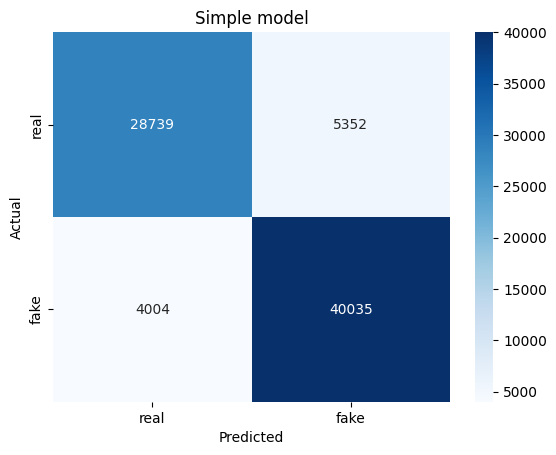


Advanced model:
Test set:
f1 score: 0.8808376217947766
accuracy score: 0.8971585818507616


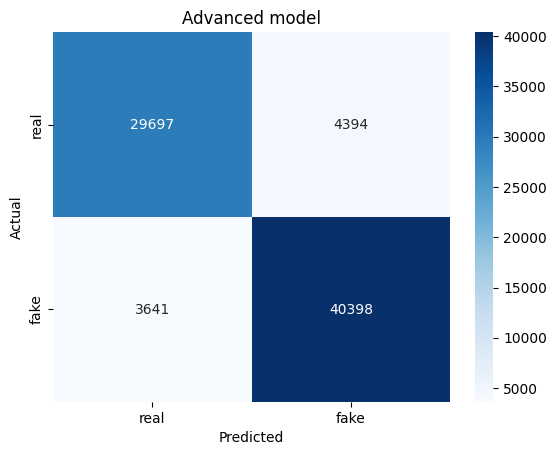

In [26]:
from joblib import load
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy.sparse import hstack
import sklearn.metrics as metrics

simple_model = load('models/simple_model_combined.joblib')
advanced_model = load('models/svm_12000.joblib')

pipeline_bow = Pipeline([
    ('vectorizer', CountVectorizer(max_features=5000, token_pattern=r'<[\w]+>|[\w]+')), 
    ('scaler', StandardScaler(with_mean=False)),
    ])
# 3500 hvis titler er med
pipeline_tfidf = Pipeline([
    ('vectorizer', TfidfVectorizer(lowercase = False, 
                                   max_features=12000, 
                                   min_df = 1, 
                                   max_df= 0.9, 
                                   token_pattern=r'<[\w]+>|[\w]+',
                                   ngram_range =  (1, 1))),
    ('scaler', StandardScaler(with_mean=False)),
    ])

BoW_content_train = pipeline_bow.fit_transform(content_train)
BoW_content_test = pipeline_bow.transform(content_test)

BoW_title_train = pipeline_bow.fit_transform(title_train)
BoW_title_test = pipeline_bow.transform(title_test)

combined_test_bow = hstack((BoW_content_test, BoW_title_test))
simple_pred_test = simple_model.predict(combined_test_bow)

accuracy_simple = metrics.accuracy_score(y_test, simple_pred_test)
f1_simple = metrics.f1_score(y_test, simple_pred_test)

print("\nSimple model:")
print("Test set:")
print("f1 score:", f1_simple)
print("accuracy score:", accuracy_simple)
make_confusion_matrix(y_test, simple_pred_test, "Simple model")

content_train_tfidf = pipeline_tfidf.fit_transform(content_train)
content_test_tfidf = pipeline_tfidf.transform(content_test)

title_train_tfidf = pipeline_tfidf.fit_transform(title_train)
title_test_tfidf = pipeline_tfidf.transform(title_test)

combined_test_tfidf = hstack((content_test_tfidf, title_test_tfidf))
advanced_pred_test = advanced_model.predict(combined_test_tfidf)

accuracy_advanced = metrics.accuracy_score(y_test, advanced_pred_test)
f1_advanced = metrics.f1_score(y_test, advanced_pred_test)

print("\nAdvanced model:")
print("Test set:")
print("f1 score:", f1_advanced)
print("accuracy score:", accuracy_advanced)
make_confusion_matrix(y_test, advanced_pred_test, "Advanced model")

### Testing Models on LIAR dataset

The LIAR dataset only has around 7000 features when combining the whole dataset. Our models are trained on higher amounts of features. Therefore we need to retrain our models on the FakeNewsCorpus with lower amounts of features. Since we combine a content vector and a title vector, they can in total only have 7000 features or 3500 features each. By doing this we have two models trained on 7000 features which can be used to make preditcions on the LIAR dataset. 

In [27]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from joblib import load
from scipy.sparse import hstack

liar_train = pd.read_csv('train.tsv', sep='\t', header=None)
liar_val = pd.read_csv('valid.tsv', sep='\t', header=None)
liar_test = pd.read_csv('test.tsv', sep='\t', header=None)
liar = pd.concat([liar_train, liar_val, liar_test], ignore_index=True)
liar_cpy = liar.copy()

liar_cpy[2] = liar_cpy[2].apply(clean_text)
tokenizer = RegexpTokenizer(r'<[\w]+>|[\w]+')
liar_cpy[2] = liar_cpy[2].apply(tokenizer.tokenize)
liar_cpy[2] = liar_cpy[2].apply(rmv_stopwords)
liar_cpy[2] = liar_cpy[2].apply(stem_tokens)
liar_cpy[2] = liar_cpy[2].apply(lambda x: ' '.join(x))

labels_used = ['pants-fire', 'false', 'mostly-true', 'true']
liar_cpy = liar_cpy.dropna(subset=[1])
liar_cpy = liar_cpy[liar_cpy[1].isin(labels_used)]
liar_cpy[1] = liar_cpy[1].map({'pants-fire': 1, 
                                         'false': 1, 
                                         'mostly-true': 0, 
                                         'true': 0})
liar_cpy = liar_cpy.dropna(subset=[2])

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

pipeline_bow = Pipeline([
    ('vectorizer', CountVectorizer(max_features=3500, token_pattern=r'<[\w]+>|[\w]+')), 
    ('scaler', StandardScaler(with_mean=False)),
    ])

BoW_content_train = pipeline_bow.fit_transform(content_train)
BoW_title_train = pipeline_bow.fit_transform(title_train)
combined_train_bow = hstack((BoW_content_train, BoW_title_train))
simple_model = LogisticRegression(max_iter=10000, random_state=42)  
simple_model.fit(combined_train_bow, y_train)

advanced_model = load('models/svm_1gram.joblib')


Simple model:
Liar dataset:
f1 score: 0.40352744412346053
accuracy score: 0.513335814415085


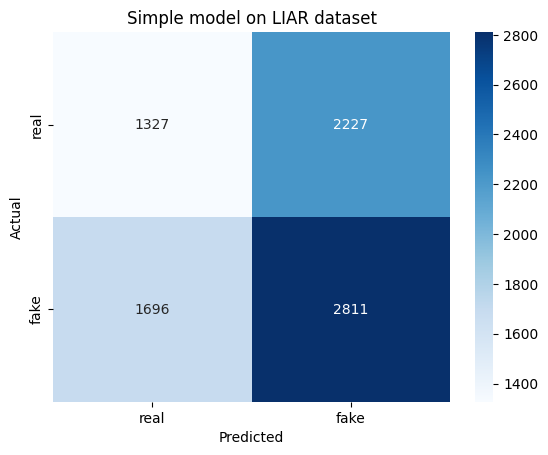


Advanced model:
Liar dataset:
f1 score: 0.4184606310822766
accuracy score: 0.5107306785758591


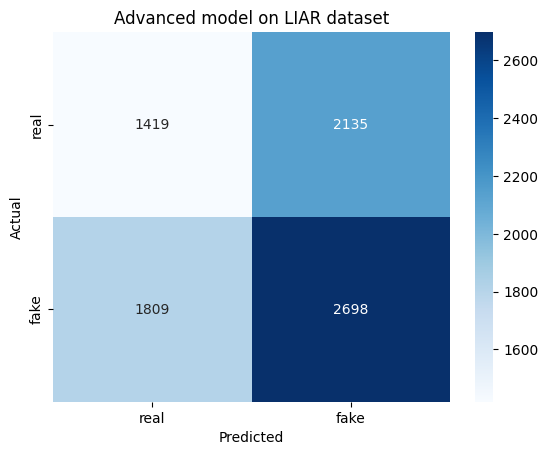

In [62]:
simple_model.fit(combined_train_bow, y_train)
pipeline_bow = Pipeline([
    ('vectorizer', CountVectorizer(max_features=7000, token_pattern=r'<[\w]+>|[\w]+')), 
    ('scaler', StandardScaler(with_mean=False)),
    ])
# 3500 hvis titler er med
pipeline_tfidf = Pipeline([
    ('vectorizer', TfidfVectorizer(lowercase = False, 
                                   max_features=7000, 
                                   min_df = 1, 
                                   max_df= 0.9, 
                                   token_pattern=r'<[\w]+>|[\w]+',
                                   ngram_range =  (1, 1))),
    ('scaler', StandardScaler(with_mean=False)),
    ])
x_liar = liar_cpy[2]
y_liar = liar_cpy[1]

liar_bow = pipeline_bow.fit_transform(x_liar, y_liar)

simple_pred_liar = simple_model.predict(liar_bow)

accuracy_simple_liar = metrics.accuracy_score(y_liar, simple_pred_liar)
f1_simple_liar = metrics.f1_score(y_liar, simple_pred_liar)
print("\nSimple model:")
print("Liar dataset:")
print("f1 score:", f1_simple_liar)
print("accuracy score:", accuracy_simple_liar)
make_confusion_matrix(y_liar, simple_pred_liar, "Simple model on LIAR dataset")

liar_tfidf = pipeline_tfidf.fit_transform(x_liar, y_liar)
advanced_pred_liar = advanced_model.predict(liar_tfidf)

accuracy_advanced_liar = metrics.accuracy_score(y_liar, advanced_pred_liar)
f1_advanced_liar = metrics.f1_score(y_liar, advanced_pred_liar)

print("\nAdvanced model:")
print("Liar dataset:")
print("f1 score:", f1_advanced_liar)
print("accuracy score:", accuracy_advanced_liar)
make_confusion_matrix(y_liar, advanced_pred_liar, "Advanced model on LIAR dataset")